<a href="https://colab.research.google.com/github/geonextgis/Mastering-Machine-Learning-and-GEE-for-Earth-Science/blob/main/00_geemap/03_Download_Image_and_Image_Tiles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Download Image and Image Tiles from Earth Engine**

## **Import Required Libraries**

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
# %pip install rasterio

In [ ]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import ee
import geemap
import rasterio

## **Initialize a Map**

In [ ]:
# # Trigger the authentication flow.
# ee.Authenticate()

# # Initialize the library.
# ee.Initialize(project='my-project')

In [ ]:
Map = geemap.Map(height="400pt")
Map

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

## **Define a Region of Interest**

In [ ]:
# Read the shapefile of the West Bengal state using geopandas
shp_path = r"/content/drive/MyDrive/Colab Notebooks/GitHub Repo/Mastering-Machine-Learning-and-GEE-for-Earth-Science/Datasets/West_Bengal_Boundary/District_shape_West_Bengal.shp"
wb_gdf = gpd.read_file(shp_path)
print(wb_gdf.shape)
wb_gdf.head()

(24, 5)


,GM_LAYER,NAME,NAME_0,NAME_1,geometry
0,Unknown Area Type,Jhargram,India,West Bengal,"POLYGON ((87.07253 22.72494, 87.07639 22.72033..."
1,Unknown Area Type,Kalimpong,India,West Bengal,"POLYGON ((88.43195 27.08161, 88.43962 27.08417..."
2,Unknown Area Type,Kolkata,India,West Bengal,"POLYGON ((88.40731 22.55647, 88.40570 22.55393..."
3,Unknown Area Type,Paschim Barddhaman,India,West Bengal,"POLYGON ((87.57518 23.52770, 87.57636 23.52456..."
4,Unknown Area Type,Pashchim Medinipur,India,West Bengal,"POLYGON ((87.88528 22.52200, 87.88857 22.51518..."


In [ ]:
# Filter the 'Bankura' district from the geodataframe
roi_gdf = wb_gdf[wb_gdf['NAME']=="Bankura"]
roi_gdf

,GM_LAYER,NAME,NAME_0,NAME_1,geometry
6,Unknown Area Type,Bankura,India,West Bengal,"POLYGON ((86.89942 23.63156, 86.91116 23.62734..."


In [ ]:
# Push the filtered geometry to the Earth Engine
roi_ee = geemap.gdf_to_ee(roi_gdf)

vis_params = {
    "fillColor": "00000000",
    "color": "black",
    "width": 1
}
Map.addLayer(roi_ee.style(**vis_params), {}, "ROI")
Map.centerObject(roi_ee, 9)

## **Band Arithmetic on Landsat Data**

### **Filtering Landsat 9 Image Collection**

In [ ]:
# Read Landsat 9 image collection from EE
L9 = ee.ImageCollection("LANDSAT/LC09/C02/T1_L2")

# Filter the image collection with roi, daterange, and cloud cover property
L9Filtered = L9.filterBounds(roi_ee)\
               .filterDate("2022-01-01", "2022-12-31")\
               .filterMetadata("CLOUD_COVER", "less_than", 50)

# Print the size of the filtered image collection
L9Filtered.size().getInfo()

27

### **Preprocessing on Landsat Data**

In [ ]:
# Write a function to rename Landsat 9 band names
def renameL9(image):
    # Define the existing band names
    band_names = ['SR_B1', 'SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6',
                  'SR_B7', 'SR_QA_AEROSOL', 'ST_B10', 'ST_ATRAN', 'ST_CDIST', 'ST_DRAD',
                  'ST_EMIS', 'ST_EMSD', 'ST_QA', 'ST_TRAD', 'ST_URAD', 'QA_PIXEL',
                  'QA_RADSAT']

    # Define the new band names
    new_band_names = ['COASTAL', 'BLUE', 'GREEN', 'RED', 'NIR', 'SWIR1',
                      'SWIR2', 'AEROSOL', 'THERMAL', 'ST_ATRAN', 'ST_CDIST', 'ST_DRAD',
                      'ST_EMIS', 'ST_EMSD', 'ST_QA', 'ST_TRAD', 'ST_URAD', 'QA_PIXEL',
                      'QA_RADSAT']

    # Rename the band names
    return image.rename(new_band_names)

In [ ]:
# Write a function to remove clouds from Landsat 9 imagery
def maskL9CloudsAndShadows(image):

    # Read the 'QA_PIXEL' (Quality Assessment) band
    qa = image.select("QA_PIXEL")

    # Define all the variables
    dilated_cloud_bitmask = 1 << 1
    cirrus_bitmask = 1 << 2
    cloud_bitmask = 1 << 3
    cloud_shadow_bitmask = 1 << 4

    # Create a mask
    mask = qa.bitwiseAnd(dilated_cloud_bitmask).eq(0).And(
           qa.bitwiseAnd(cirrus_bitmask).eq(0)).And(
           qa.bitwiseAnd(cloud_bitmask).eq(0)).And(
           qa.bitwiseAnd(cloud_shadow_bitmask).eq(0))

    return image.updateMask(mask)

### **Function to Calculate Various Spectral Indices**

In [ ]:
# Write a function to calculate NDVI, NDWI, MNDWI, NDBI, BU, SAVI, EVI, GCVI of an image
def calculateIndices(image):

    # NDVI = (NIR - RED) / (NIR + RED)
    NDVI = image.normalizedDifference(["NIR", "RED"])\
                .rename("NDVI")

    # NDWI = (NIR – SWIR1) / (NIR + SWIR1)
    NDWI = image.normalizedDifference(["NIR", "SWIR1"])\
                .rename("NDWI")

    # MNDWI = (Green - SWIR1) / (Green + SWIR1)
    MNDWI = image.normalizedDifference(["GREEN", "SWIR1"])\
                 .rename("MNDWI")

    # NDBI = (SWIR – NIR) / (SWIR + NIR)
    NDBI = image.normalizedDifference(["SWIR1", "NIR"])\
                .rename("NDBI")

    # BU = NDBI - NDVI
    BU = NDBI.subtract(NDVI)\
             .rename("BU")

    # SAVI = ((NIR – RED) / (NIR + RED + 0.5)) * (1.5)
    SAVI = image.expression(
        "((NIR - RED) / (NIR + RED + 0.5)) * (1.5)", {
            "NIR": image.select("NIR"),
            "RED": image.select("RED")
    }).rename("SAVI")

    # EVI = 2.5 * ((NIR - RED) / (NIR + 6 * RED - 7.5 * BLUE + 1))
    EVI = image.expression(
        "2.5 * ((NIR - RED) / (NIR + 6 * RED - 7.5 * BLUE + 1))", {
            "NIR": image.select("NIR"),
            "RED": image.select("RED"),
            "BLUE": image.select("BLUE")
    }).rename("EVI")

    # GCVI = (NIR/GREEN) − 1
    GCVI = image.expression(
        "(NIR / GREEN) - 1", {
            "NIR": image.select("NIR"),
            "GREEN": image.select("GREEN")
    }).rename("GCVI")

    # Add all the indices in a single ee list
    final_image = ee.Image([NDVI, NDWI, MNDWI, NDBI, BU, SAVI, EVI, GCVI])\
                    .copyProperties(image, ["system:time_start"])

    return ee.Image(final_image)

### **Implementation on an Image Collection**

In [ ]:
# Apply 'renameL9', 'maskL9CloudsAndShadows', and 'calculateIndices' function on the whole image collection
# to create a cloud free median composite spectral indices image of the whole year
medianIndicesL9= L9Filtered.map(renameL9)\
                           .map(maskL9CloudsAndShadows)\
                           .map(calculateIndices)\
                           .median()\
                           .clip(roi_ee)

# Display only the NDVI image
NDVI_vis = {
    "min": 0,
    "max": 0.3,
    "bands": ["NDVI"],
    "palette": ["#a50026", "#da372a", "#f67b4a", "#fdbf6f", "#feeea2",
                "#eaf6a2", "#b7e075", "#74c365", "#229c52", "#006837"]
}

Map.addLayer(medianIndicesL9, NDVI_vis, "L9 Median NDVI")

## **Download the Full Image to Drive**

🤔 **Note:** Prior to downloading the image, it is crucial to explicitly specify the projection of the image.

In [ ]:
# Define the projection
proj = ee.Projection("EPSG:32645")

# Reproject the 'medianIndicesL9' image
medianIndicesL9 = medianIndicesL9.reproject(proj, crsTransform=None, scale=30)

In [ ]:
# Check the current projection and scale of the image
print("Projection Information:", medianIndicesL9.projection().getInfo())
print("Spatial Resolution:", medianIndicesL9.projection().nominalScale().getInfo())

Projection Information: {'type': 'Projection', 'crs': 'EPSG:32645', 'transform': [30, 0, 0, 0, -30, 0]}
Spatial Resolution: 30


In [ ]:
# Specify the output file path and file name
output_path = "/content/drive/MyDrive/GEE//"
file_name = "Median_Indices_2022.tif"
geemap.download_ee_image(image=medianIndicesL9,
                         filename=output_path+file_name,
                         region=roi_ee.geometry(),
                         scale=30)

Median_Indices_2022.tif: |          | 0.00/952M (raw) [  0.0%] in 00:00 (eta:     ?)

## **Read the Image using Rasterio**

In [ ]:
# Read the 'Median_Indices_2022.tif' image
src = rasterio.open(output_path+file_name)

# Store all the metadata
raster_meta = src.meta
driver = raster_meta["driver"]
dtype = raster_meta["dtype"]
nodata = raster_meta["nodata"]
width = raster_meta["width"]
height = raster_meta["height"]
count = raster_meta["count"]
crs = raster_meta["crs"]
transform = raster_meta["transform"]

# Print the metadata of the raster
src.meta

{'driver': 'GTiff',
 'dtype': 'float64',
 'nodata': nan,
 'width': 3964,
 'height': 3754,
 'count': 8,
 'crs': CRS.from_epsg(32645),
 'transform': Affine(30.0, 0.0, 459390.0,
        0.0, -30.0, 2614380.0)}

In [ ]:
# Store all the band names in a variable
band_names = src.descriptions
band_names

('NDVI', 'NDWI', 'MNDWI', 'NDBI', 'BU', 'SAVI', 'EVI', 'GCVI')

In [ ]:
# Convert the raster image into an array
raster_arr = src.read()

# Close the source file
src.close()

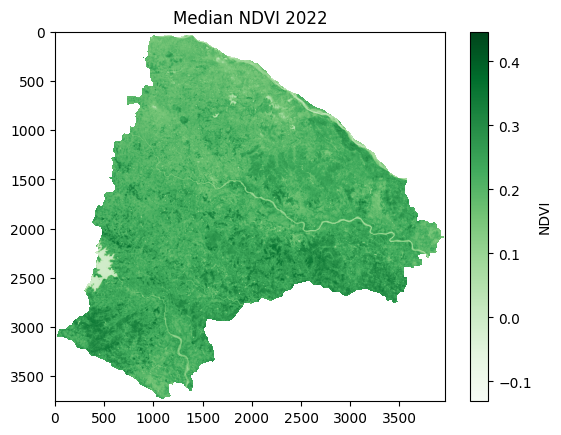

In [ ]:
# Plot the NDVI image
plt.figure()
plt.imshow(raster_arr[0], cmap="Greens")
plt.colorbar(label="NDVI")
plt.title("Median NDVI 2022")
plt.show()

🤔 **Note:** <br>When working with raster images, especially in scenarios involving larger regions of interest (ROIs) and high spatial resolution, it's imperative to optimize the processing strategy for efficiency. Processing the entire image at once can be computationally intensive, leading to increased memory usage and slower performance. To overcome these challenges, a more effective approach involves dividing the image into smaller tiles and processing each tile individually. This not only conserves memory but also significantly improves processing speed.

## **Download the Image by Tiles**

In [ ]:
# Extract the bounding box of the ROI as a polygon
roi_boundary = roi_ee.geometry().bounds()

# Create a mesh grid
mesh = geemap.fishnet(roi_boundary, rows=2, cols=2, delta=0)
Map.addLayer(mesh.style(**vis_params), {}, "Mesh Grid")

In [ ]:
# Download the image by tiles
geemap.download_ee_image_tiles(image=medianIndicesL9,
                               features=mesh,
                               out_dir=output_path,
                               prefix="Median_Indices_2022_",
                               crs="EPSG:32645",
                               scale=30)

Median_Indices_2022_1.tif: |          | 0.00/238M (raw) [  0.0%] in 00:00 (eta:     ?)

Median_Indices_2022_2.tif: |          | 0.00/239M (raw) [  0.0%] in 00:00 (eta:     ?)

Median_Indices_2022_3.tif: |          | 0.00/237M (raw) [  0.0%] in 00:00 (eta:     ?)

Median_Indices_2022_4.tif: |          | 0.00/238M (raw) [  0.0%] in 00:00 (eta:     ?)

Downloaded 4 tiles in 281.60299348831177 seconds.
